In [1]:
import os, sys, time, resource, re, gc, shutil
from multiprocess import Pool
from functools import partial


from urllib.parse import urlparse, parse_qsl
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mongoengine.queryset.visitor import Q
import django
from django.db.models import Count
sys.path.append('/home/galm/software/django/tmv/BasicBrowser/')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

from scoping.models import *
from tmv_app.models import *
from django.db.models import F, Sum, Count
from matplotlib import gridspec

from utils.utils import *


from run_id import run_id

run_id = 1861

runstat = RunStats.objects.get(pk=run_id)

q = runstat.query


In [2]:
ar5 = AR.objects.get(ar=5)

docs = Doc.objects.filter(query=runstat.query,PY__lte=ar5.end)

docs.count()

206342

In [3]:
citations = IPCCRef.objects.all()

citations.count()

matched = citations.filter(doc__isnull=False)

inq = citations.filter(doc__query=6187)

unmatched = citations.filter(doc__isnull=True)

print("Matched {} documents\n".format(matched.count()))

print("Didn't match {} documents\n".format(unmatched.count()))

print("{:.2%} of documents in query\n".format(inq.count()/(matched.count()+unmatched.count())))

print("Matched {}% of documents\n".format(matched.count()/(matched.count()+unmatched.count())))

Matched 39656 documents

Didn't match 33822 documents

37.58% of documents in query

Matched 0.5396989575110918% of documents



In [4]:
df = pd.DataFrame.from_dict(list(unmatched.values('text','year')))
df.head()

,text,year
0,Southwest Energy Efficiency Project. Energy Ef...,2011
1,"Salmonella infections in a marsupial, the Qu...",1985
2,I P C C Guidelines for N a t i o n a l Greenho...,1995
3,World A g r i c u l t u r e and C l i m a t e ...,1995
4,Relationship between ancient channel and seawa...,1999


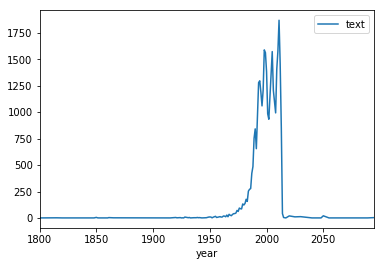

In [5]:
df.groupby(['year']).count().plot()

plt.show()

In [6]:
df.groupby(['year']).count()

,text
year,
1800,2
1801,1
1815,2
1819,1
1820,1
1837,1
1843,1
1848,1
1850,6


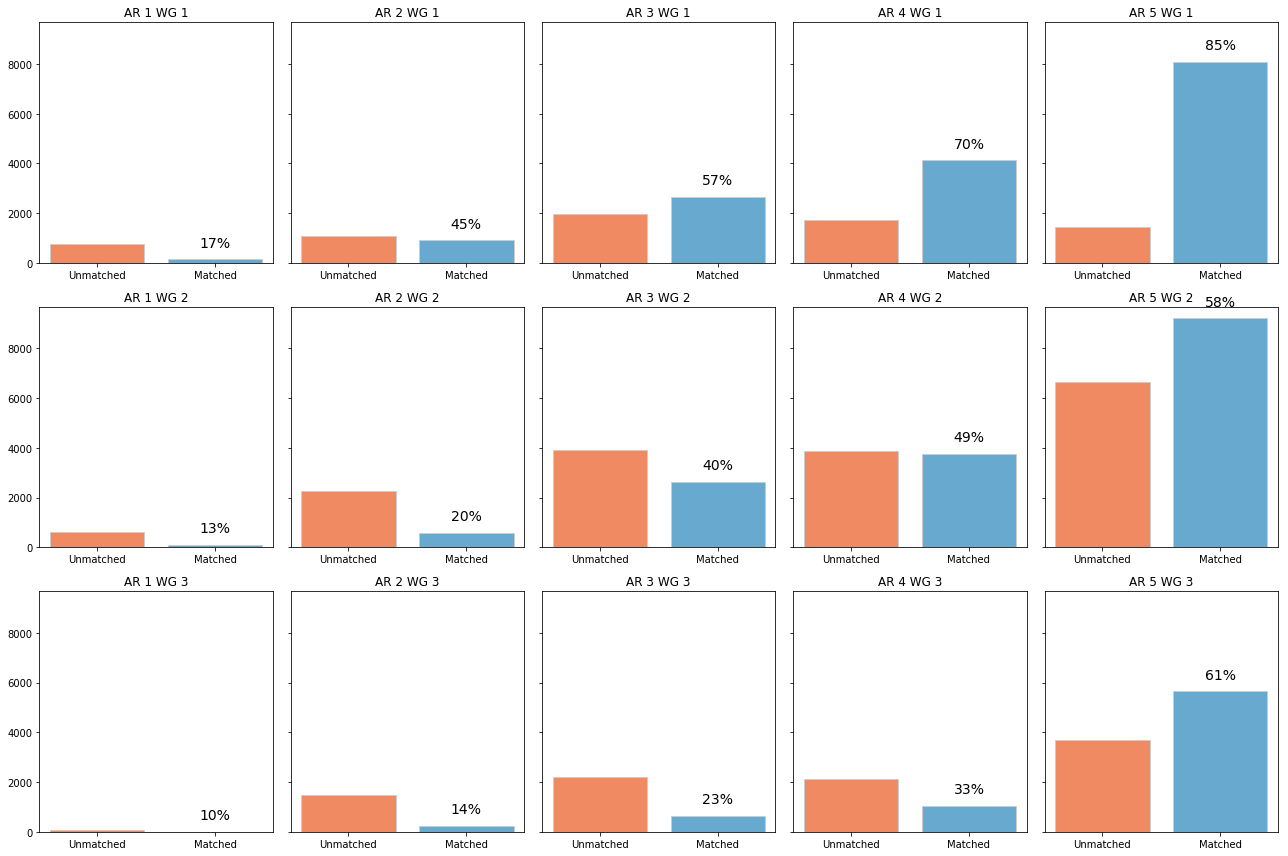

In [7]:
plt.rcParams["figure.figsize"] = [18,12]

fig, axs = plt.subplots(
    nrows=3,
    ncols=5,
    sharey=True#,
    #gridspec_kw=dict(hspace=0.4,)
)

wgdf_rows = []

for wg in WG.objects.all().order_by('ar','wg'):
    ax = axs[wg.wg-1][wg.ar.ar-1]
    irs = IPCCRef.objects.filter(
        ar=wg.ar,
        wg=wg
    )
    matched = irs.filter(doc__isnull=False).count()
    unmatched = irs.filter(doc__isnull=True).count()
    pcntage = round(matched / (matched+unmatched) * 100)
    ax.text(1,matched+500,"{}%".format(pcntage),ha="center",fontsize=14)
    
    ax.bar([0,1],[unmatched,matched],color=["#ef8a62","#67a9cf"],edgecolor="#cccccc", linewidth=1)
    ax.set_xticks([0,1])
    ax.set_xticklabels(["Unmatched","Matched"])
    ax.set_title('AR {:.0f} WG {:.0f}'.format(wg.ar.ar,wg.wg))
    #ax.annotate("{}%".format(pcntage),(1,matched+500),ha="center",fontsize=14)
    
    wgdf_rows.append({
        'AR': wg.ar,
        'WG': wg.wg,
        'pcnt': matched / (matched+unmatched) 
    })
    
fig.tight_layout()
    
plt.savefig('../plots/ipcc_matches.png',bbox_inches='tight')   
plt.show()

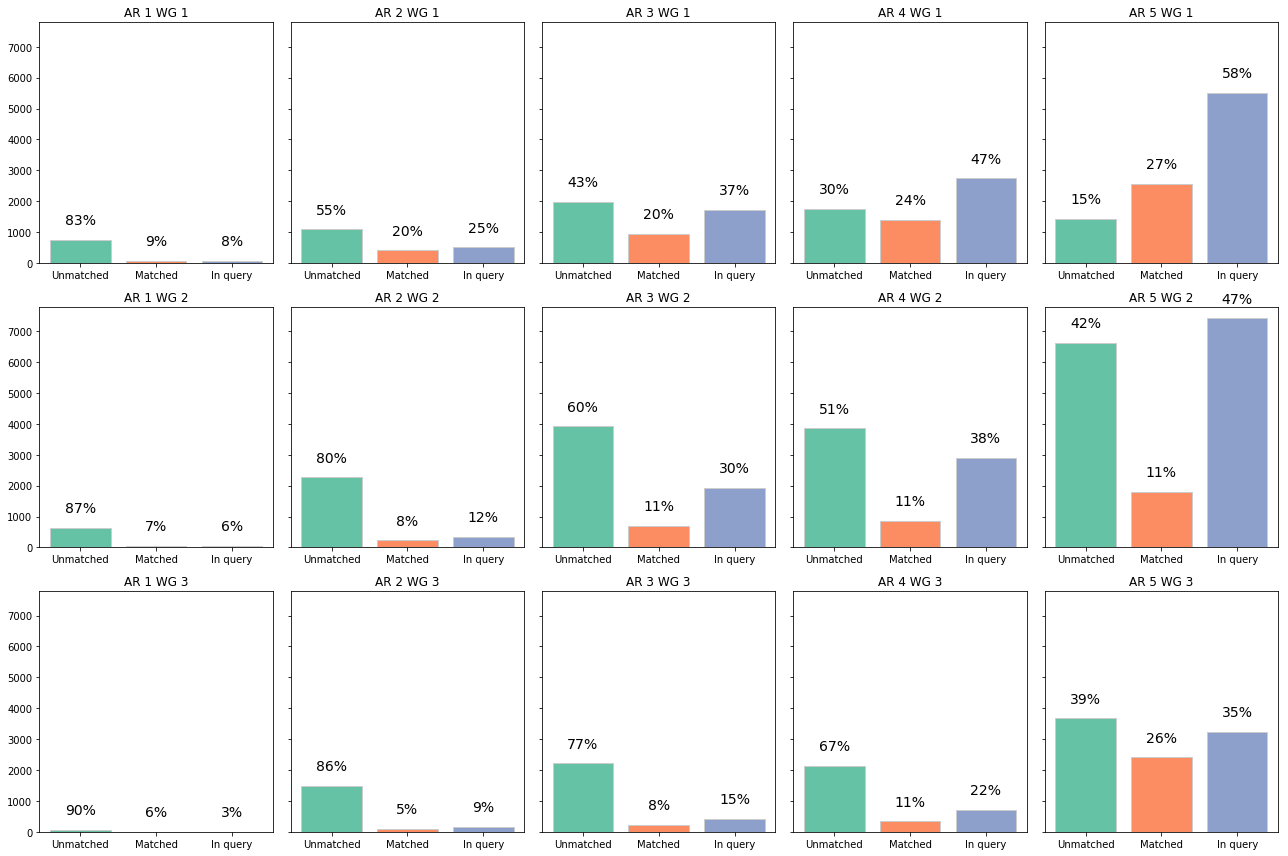

In [8]:
plt.rcParams["figure.figsize"] = [18,12]

fig, axs = plt.subplots(
    nrows=3,
    ncols=5,
    sharey=True#,
    #gridspec_kw=dict(hspace=0.4,)
)

wgdf_rows = []

for wg in WG.objects.all().order_by('ar','wg'):
    ax = axs[wg.wg-1][wg.ar.ar-1]
    irs = IPCCRef.objects.filter(
        ar=wg.ar,
        wg=wg
    )
    inq = irs.filter(doc__query=6187).count()
    matched = irs.filter(doc__isnull=False).exclude(doc__query=6187).count()
    unmatched = irs.filter(doc__isnull=True).count()
    total = irs.count()
    

    for i,m in enumerate([unmatched, matched, inq]):
        ax.text(i,m+500,f"{m/total:.0%}",ha="center",fontsize=14)
        
    ax.bar(
        [0,1,2],
        [unmatched, matched, inq],
        color=['#66c2a5','#fc8d62','#8da0cb'],
        edgecolor="#cccccc", linewidth=1
    )
    ax.set_xticks([0,1,2])
    ax.set_xticklabels(["Unmatched","Matched","In query"])
    ax.set_title('AR {:.0f} WG {:.0f}'.format(wg.ar.ar,wg.wg))
    #ax.annotate("{}%".format(pcntage),(1,matched+500),ha="center",fontsize=14)
    
    wgdf_rows.append({
        'AR': wg.ar,
        'WG': wg.wg,
        'pcnt': inq / (total) 
    })
    
fig.tight_layout()
    
plt.savefig('../plots/ipcc_matches.png',bbox_inches='tight')   
plt.show()

In [9]:
wgdf = pd.DataFrame.from_dict(wgdf_rows)

wgdf_wide = wgdf.pivot(index="WG",columns="AR",values="pcnt")

wgdf_wide.to_latex('../tables/ipcc_matching.tex',float_format='{:.0%}'.format)

In [10]:
p = Project.objects.get(pk=110)
search_ids = []
qs = Query.objects.filter(project=p)
for q in qs.iterator():
    search_ids += q.title.split(' OR ')
search_ids = set(search_ids)

In [11]:

q = runstat.query
irs = IPCCRef.objects.filter(ar=5)
in_db = irs.filter(doc__isnull=False)
in_hc = irs.filter(doc__query=q)
found = set(irs.filter(doc__query__project=p))
unfound = search_ids - found
no_db = set(irs.filter(doc__isnull=True).values_list('pk',flat=True))
unlooked = no_db - search_ids

print(f"IPCC refs: {irs.count()}")
print(f"In db: {in_db.count()}")
print(f"In Grineisen: {in_hc.count()}")
print(f"Found: {len(found)}")
print(f"not found: {len(unfound)}")
print(f"still to search: {len(unlooked)}")

IPCC refs: 34609
In db: 22889
In Grineisen: 16130
Found: 3325
not found: 9469
still to search: 11720


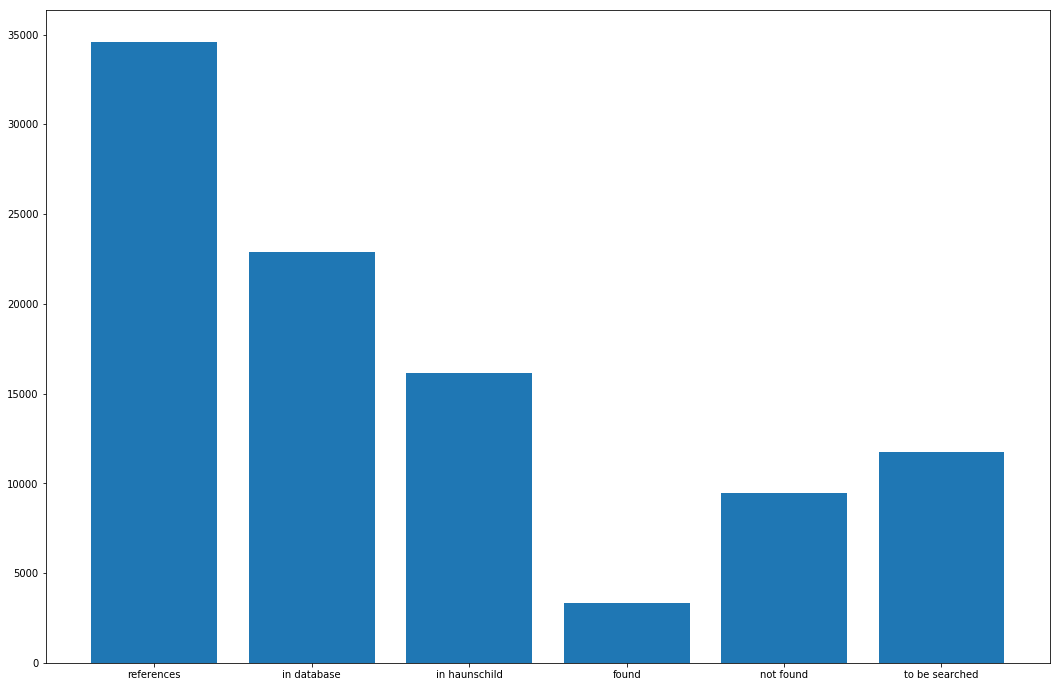

In [12]:
fig, ax = plt.subplots()
x = [0,1,2,3,4,5]
ax.bar(
    x,
    [irs.count(),in_db.count(),in_hc.count(),len(found),len(unfound),len(unlooked)]
)
ax.set_xticks(x)
ax.set_xticklabels([
    "references",
    "in database",
    "in haunschild",
    "found",
    "not found",
    "to be searched"
])

plt.savefig("../plots/ipcc_matching.png")

In [13]:
unmatched

3675

In [14]:
irs = IPCCRef.objects.all()
unmatched = irs.filter(doc__isnull=True, checked_count__gt=3).values_list('pk',flat=True)


def random_list(l,n):
    print(l)
    return [ l[i] for i in sorted(random.sample(range(len(l)), n)) ]

ir_sample = IPCCRef.objects.filter(id__in=random_list(unmatched,10))

df = pd.DataFrame.from_dict(list(ir_sample.values('text','ar','wg__wg','authors','year')))

df.head(10)


<QuerySet [74618, 20568, 12029, 18992, 42681, 40166, 33249, 22987, 38624, 47760, 27079, 18949, 38078, 33693, 32877, 12585, 59310, 22967, 51585, 18121, '...(remaining elements truncated)...']>


,ar,authors,text,wg__wg,year
0,3,"Leemans, R. and W. Cramer",The IIASA Database for Mean Monthly Values o...,1,1991
1,2,"Dutto, F. and G. Mortara",Rischi connessi con la dinámica glaciale nelle...,2,1992
2,3,"Visbeck, M., J. Marshall, T. Haine and M. Spall",Specification of eddy transfer coefficients ...,1,1997
3,3,"Gordon, G., A.S. Brown, and T. Pulsford",A koala (Phascolartos cinereus Goldfuss) pop...,2,1988
4,4,"Isaev, A., V. Stolbovoi, V. Kotlyakov, S. Nils...",Climate change and land resources of Russia.,2,2004
5,4,"Gehl, S",Generation technology choices: near and long t...,3,2004
6,4,"Viner, D., M. Sayer, M. Uyarra, and N. Hodgson",Climate Change and the European Countryside: I...,3,2006
7,5,"Smit, B. and O. Pilifosova",Adaptation to climate change in the context of...,2,2001
8,5,COP,Copenhagen City of Cyclists: Bicycle Account 2...,3,2010
9,5,"Reilly J M, J A Edmonds, R H Gardner, and A L ...",Uncertainty analysis of the IEA / ORAU CO2 emi...,3,1987


In [15]:
for ir in ir_sample:
    print(ir.wg.all())
    print(f"{ir.text} - {ir.authors} ({ir.year})")
    print()

<QuerySet [<WG: AR3 WG1>]>
The IIASA Database for Mean Monthly   Values of Temperature, Precipitation and Cloudiness on a Global Terrestrial   Grid. IIASA Report RR-91-18, Laxenburg, 63 pp. - Leemans, R. and W. Cramer (1991)

<QuerySet [<WG: AR2 WG2>]>
Rischi connessi con la dinámica glaciale nelle Alpi ItaUane. Geografía Física e Dinámica Quatemaría, 15, 85-99.  - Dutto, F. and G. Mortara (1992)

<QuerySet [<WG: AR3 WG1>]>
Specification   of eddy transfer coefficients in coarse-resolution ocean circulation models.   J. Phys. Oceanogr., 27, 381-402. - Visbeck, M., J. Marshall, T. Haine and M. Spall (1997)

<QuerySet [<WG: AR3 WG2>]>
A koala (Phascolartos   cinereus Goldfuss) population crash during drought and heatwave conditions in   south-western Queensland. Australian Journal of Ecology, 13, 451-461. - Gordon, G., A.S. Brown, and T. Pulsford (1988)

<QuerySet [<WG: AR4 WG2>]>
Climate change and land resources of Russia. - Isaev, A., V. Stolbovoi, V. Kotlyakov, S. Nilsson and I. McCa

In [16]:
cformat = 'l l p{4.5cm} p{2.5cm} r'

df = df.rename(columns={"wg__wg":"WG","ar":"AR"})
df = df[['AR','WG','text','authors','year']]
df.head()
with pd.option_context('display.max_colwidth', -1):
    df.to_latex('../tables/ipcc_matching_sample.tex',column_format=cformat,index=False)

In [17]:
ar_matches = IPCCRef.objects.filter(wg__ar__in=range(1,6)).values('wg__ar').annotate(
    matched = models.Sum(
        models.Case(
            models.When(
                doc__isnull=False,
                then=1
            ),
            default=0,
            output_field=models.FloatField()
        )
    ),
    unmatched = models.Sum(
        models.Case(
            models.When(
                doc__isnull=True,
                then=1
            ),
            default=0,
            output_field=models.FloatField()
        )
    )
).order_by('wg__ar')

matching_df = pd.DataFrame.from_dict(list(ar_matches))

matching_df.head()

,matched,unmatched,wg__ar
0,252.0,1434.0,1
1,1733.0,4847.0,2
2,5946.0,8104.0,3
3,8950.0,7742.0,4
4,22936.0,11738.0,5
